In [2]:
pip install requests beautifulsoup4 robustbase


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: C:\Users\Basmala Kamal\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [3]:
import requests
from bs4 import BeautifulSoup
from sklearn.covariance import MinCovDet
from scipy.stats import chi2
import numpy as np
from sklearn.preprocessing import MinMaxScaler



In [7]:
import json
import pandas as pd
import re

# 1. Load the JSON file
with open("B:/tut-pricing-model/face serums/faceserums_noon.json", "r", encoding="utf-8") as f:
    data = json.load(f)

# Convert to a pandas DataFrame for easier data manipulation
df = pd.DataFrame(data)
df = df.dropna(subset=["Price"])
import time


# Define the function to scrape the brand name
def scrape_brand_name(session, url):
    try:
        if not url or not url.startswith("http"):  # Validate URL
            return None

        # Send a GET request to the URL using the session
        response = session.get(url, timeout=10)
        response.raise_for_status()  # Raise an error for HTTP issues

        # Parse the page content with BeautifulSoup
        soup = BeautifulSoup(response.content, "html.parser")

        # Adjust this selector based on the actual structure of the webpage
        brand_tag = soup.find("tr", class_="a-spacing-small po-brand")
        if brand_tag:
            td_tag = brand_tag.find("td", class_="a-span9")
            if td_tag:
                span_tag = td_tag.find("span", class_="a-size-base po-break-word")
                if span_tag:
                    return span_tag.get_text(strip=True)

        # Return None if the brand name is not found
        return None

    except requests.exceptions.RequestException as e:
        print(f"Network error scraping {url}: {e}")
        return None
    except Exception as e:
        print(f"Error scraping {url}: {e}")
        return None

# Load the JSON file

"""
# Ensure the 'link' column exists and is valid
if "link" in df.columns:
    # Create a requests session
    with requests.Session() as session:
        # Set a User-Agent header to mimic a browser (optional but recommended)
        session.headers.update({
            "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/113.0.0.0 Safari/537.36"
        })

        # Apply the scraping function to the 'link' column
        brand_names = []
        for idx, url in enumerate(df["link"]):
            print(f"Scraping {idx + 1}/{len(df)}: {url}")
            brand_name = scrape_brand_name(session, url)
            brand_names.append(brand_name)

            # Throttle requests to avoid getting blocked
            time.sleep(2)

        # Add the scraped brand names to the DataFrame
        df["brand_name"] = brand_names"""

def clean_price(price_str):
    if price_str is None:
        return None
    numeric_str = re.sub(r"[^\d\.]", "", price_str)
    try:
        return float(numeric_str)
    except ValueError:
        return None

df["price_numeric"] = df["Price"].apply(clean_price)


def clean_rating(rating_str):
    if rating_str is None:
        return None

    match = re.search(r"\d+(\.\d+)?", rating_str)
    if match:
        try:
            return float(match.group(0))
        except ValueError:
            return None
    return None

#df["rating_numeric"] = df["rating"].apply(clean_rating)

def extract_volume(title_str):
    # Check for "ml" first to avoid misidentification
    match_ml = re.search(r'(\d+(?:\.\d+)?)\s*ml', title_str, re.IGNORECASE)
    if match_ml:
        return float(match_ml.group(1))  # Prioritize ml if present
    else:
    # Check for "oz" (fluid ounces)
      match_oz = re.search(r'(\d+(?:\.\d+)?)\s*(?:fl\.?\s*oz|oz|fluid ounces?)', title_str, re.IGNORECASE)
      if match_oz:
         return float(match_oz.group(1)) * 29.5735  # Convert oz to ml

    # If no match, return None
    return None

# Apply the function to the DataFrame
df["volume"] = df["Product Name"].apply(extract_volume)

def remove_duplicates_by_name_and_price(df):
    # Sort the DataFrame to keep the first occurrence of each duplicate
    df = df.sort_values(by=["Product Name", "price_numeric"])

    # Drop duplicates based on 'name' and 'price_numeric'
    df = df.drop_duplicates(subset=["Product Name", "price_numeric"], keep="first")

    return df

# Apply the duplicate removal function to the DataFrame
df = remove_duplicates_by_name_and_price(df)
# ------------------------------------------------------------------------------
# Final cleaned DataFrame
df = df[~df['Product Name'].str.contains("cream", na=False)].copy()
print(df)


                                         Product Name   Price  price_numeric  \
45  9 wishes [9Wishes] Hydra Ampoule Serum Ⅱ Longl...  114.20         114.20   
29  ACM Laboratoire dermatologique ACM Love Skin B...   52.95          52.95   
19  ARTLOOK PACK OF 2-Anti Ageing Vitamin C Serum ...    8.95           8.95   
16  ARTLOOK PACK OF 3-Anti Ageing Vitamin C Serum ...   12.95          12.95   
14  Aichun beauty Aichun Beauty Serum Salicylic Ac...    3.95           3.95   
17  Aichun beauty Avocado Whitening And Brightenin...    3.95           3.95   
7   Aichun beauty Niacinamide 10% And Zinc 1% Clea...    5.95           5.95   
26  Auravedic Kumkumadi Skin Brightening Gel With ...      63          63.00   
28           Brilliant Skin Brilliant skin Cream 100g      22          22.00   
43  DERMATOUCH Kojic Acid Serum 2%| Best For Hyper...     106         106.00   
21                    DR. DAVEY Peeling Solution 30ml      27          27.00   
24  DRUNK ELEPHANT Protini Powerpeptide 

In [8]:
print(df.columns)

Index(['Product Name', 'Price', 'price_numeric', 'volume'], dtype='object')


In [11]:
import pandas as pd
from difflib import SequenceMatcher

df_cleaned = df.copy()

def is_face_serum(name):
    name = str(name).lower()
    
    # Keywords that must appear or match closely
    keywords = [
        "face serum", "facial serum", "serum", 
        "brightening serum", "anti-aging serum", 
        "anti wrinkle serum", "vitamin c serum", 
        "hyaluronic acid serum", "niacinamide serum"
    ]

    # Optional: Exclude unrelated serums or products
    exclude_keywords = [
        "hair serum", "eyelash serum", "beard serum", "body serum", 
        "booster", "toner", "mist", "deodorant", "sunscreen", "cream"
    ]

    for exclude in exclude_keywords:
        if exclude in name:
            return False

    for keyword in keywords:
        if keyword in name or SequenceMatcher(None, keyword, name).ratio() > 0.7:
            return True

    return False

# Example Usage on DataFrame
df = df[df['Product Name'].apply(is_face_serum)]
df.reset_index(drop=True, inplace=True)

# --- Step 5: Define multi-item set detection ---
def is_multi_item(name):
    name = str(name).lower()
    
    # Case 1: Set & Pieces
    if "set" in name and ("pieces" in name or "bundle" in name or "pack" in name):
        return True
    
    # Case 2: Multi-pack or similar
    if re.search(r"(2-pack|two-pack|2 bottles|two bottles|two items|two)", name, re.IGNORECASE):
        return True
    
    # Case 3: Numeric quantities
    if re.search(r"\b\d+\s*(bottles|packs?|count|piece|pieces)\b", name, re.IGNORECASE):
        return True

    return False

# --- Step 6: Remove multi-item sets ---
df_cleaned = df_cleaned[~df_cleaned["Product Name"].apply(is_multi_item)]

# --- Step 7: Final cleanup ---
df_cleaned.reset_index(drop=True, inplace=True)

# --- Step 8: Preview ---
print("Final cleaned dataset shape:", df_cleaned.shape)
print(df_cleaned.head())


Final cleaned dataset shape: (38, 4)
                                        Product Name   Price  price_numeric  \
0  9 wishes [9Wishes] Hydra Ampoule Serum Ⅱ Longl...  114.20         114.20   
1  ARTLOOK PACK OF 2-Anti Ageing Vitamin C Serum ...    8.95           8.95   
2  ARTLOOK PACK OF 3-Anti Ageing Vitamin C Serum ...   12.95          12.95   
3  Aichun beauty Aichun Beauty Serum Salicylic Ac...    3.95           3.95   
4  Aichun beauty Avocado Whitening And Brightenin...    3.95           3.95   

      volume  
0  29.869235  
1  30.000000  
2  30.000000  
3  30.000000  
4  30.000000  


In [17]:
df_multi = df_cleaned[df_cleaned["Product Name"].apply(is_multi_item)]

# --- Step 7: Final cleanup ---
df_multi.reset_index(drop=True, inplace=True)

# --- Step 8: Preview ---
print("Final cleaned dataset shape:", df_multi.shape)
print(df_multi.head())


Final cleaned dataset shape: (0, 5)
Empty DataFrame
Columns: [Product Name, Price, price_numeric, volume, price_per_volume]
Index: []


In [12]:
print(df_cleaned.columns.tolist())


['Product Name', 'Price', 'price_numeric', 'volume']


In [13]:
# Step 1: Ensure volume and price_numeric columns exist and are not accidentally DataFrames
print(type(df_cleaned["volume"]), type(df_cleaned["price_numeric"]))

# Step 2: Create the new column safely
# Ensure 'price_numeric' and 'volume' exist
if "price_numeric" in df_cleaned.columns and "volume" in df_cleaned.columns:
    df_cleaned["price_per_volume"] = df_cleaned.apply(
        lambda row: row["price_numeric"] / row["volume"]
        if pd.notna(row["price_numeric"]) and pd.notna(row["volume"]) and row["volume"] > 0
        else np.nan,
        axis=1
    )
else:
    print("Missing 'price_numeric' or 'volume' columns.")



<class 'pandas.core.series.Series'> <class 'pandas.core.series.Series'>


In [14]:
print(df_cleaned["price_numeric"].describe())


count     38.000000
mean      80.084211
std       87.763196
min        3.950000
25%       39.375000
50%       55.000000
75%       94.500000
max      496.000000
Name: price_numeric, dtype: float64


In [15]:
print(df_cleaned["price_per_volume"].describe())


count    19.000000
mean      2.188491
std       2.216688
min       0.131667
25%       0.456218
50%       1.080000
75%       3.911666
max       6.898068
Name: price_per_volume, dtype: float64


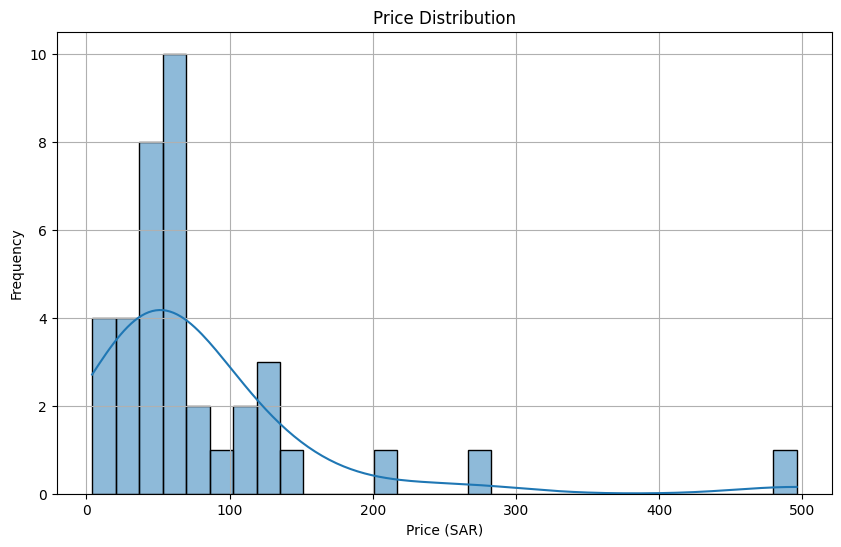

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(df_cleaned["price_numeric"].dropna(), bins=30, kde=True)
plt.title("Price Distribution")
plt.xlabel("Price (SAR)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


In [11]:
import numpy as np
from sklearn.preprocessing import StandardScaler

df_cleaned = df_cleaned.dropna(subset=["price_per_volume"]).copy()

# Apply log transformation using .loc
df_cleaned.loc[:, "price_log"] = np.log(df_cleaned["price_per_volume"])

# Then standard scale
scaler = StandardScaler()
df_cleaned.loc[:, "price_scaled"] = scaler.fit_transform(df_cleaned[["price_log"]])


C:\Users\Basmala Kamal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\Basmala Kamal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.13_3.13.1008.0_x64__qbz5n2kfra8p0\Lib\subprocess.py", line 

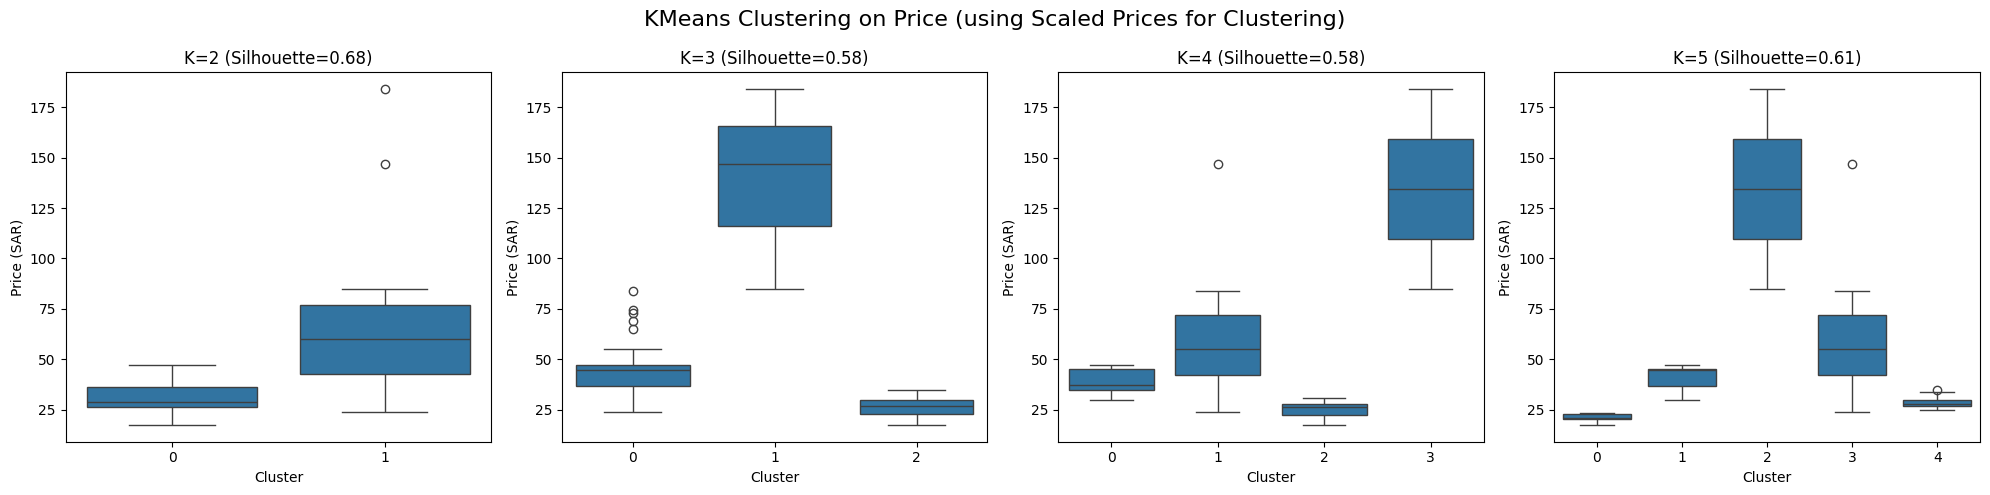

In [12]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd


# 2. Feature for clustering
X_price = df_cleaned[["price_scaled"]].values

# 3. Plot setup
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# 4. Try multiple cluster counts
for idx, k in enumerate([2, 3, 4, 5]):
    if len(df_cleaned) < k:
        print(f"Skipping k={k} due to insufficient data.")
        continue

    # Fit KMeans
    kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)
    kmeans.fit(X_price)

    # Add cluster labels to DataFrame
    cluster_col = f"cluster_k{k}"
    df_cleaned[cluster_col] = kmeans.labels_

    # Silhouette score
    if len(set(kmeans.labels_)) > 1:
        sil_score = silhouette_score(X_price, kmeans.labels_)
    else:
        sil_score = np.nan

    # Boxplot using raw prices, grouped by cluster
    sns.boxplot(
        x=cluster_col,
        y="price_numeric",  # Show real prices
        data=df_cleaned,
        ax=axes[idx]
    )
    axes[idx].set_title(f"K={k} (Silhouette={sil_score:.2f})")
    axes[idx].set_xlabel("Cluster")
    axes[idx].set_ylabel("Price (SAR)")

# Final plot formatting
plt.suptitle("KMeans Clustering on Price (using Scaled Prices for Clustering)", fontsize=16)
plt.tight_layout()
plt.show()


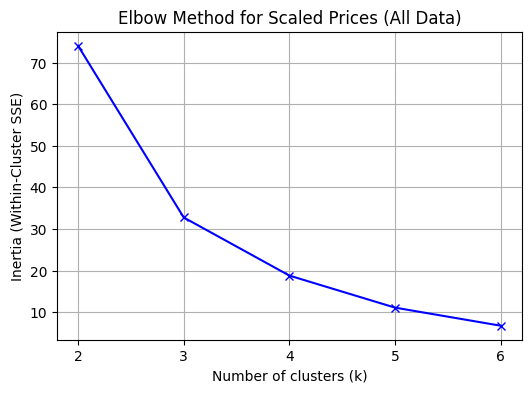

In [13]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Extract scaled price for clustering
X_price = df_cleaned[["price_scaled"]].values

# Elbow Method: Try k from 2 to 5
distortions = []
K_range = range(2, 7)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)
    kmeans.fit(X_price)
    distortions.append(kmeans.inertia_)

# Plot the Elbow curve
plt.figure(figsize=(6, 4))
plt.plot(K_range, distortions, 'bx-')
plt.title('Elbow Method for Scaled Prices (All Data)')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia (Within-Cluster SSE)')
plt.xticks(K_range)
plt.grid(True)
plt.show()


In [14]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans

# 1. Extract price_scaled values for clustering
X_price = df_cleaned[["price_scaled"]].values

# 2. Run KMeans with k=3
k = 3
kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)
kmeans.fit(X_price)

# 3. Reassign cluster labels based on ascending mean price
df_cleaned = df_cleaned.copy()
df_cleaned["temp_cluster"] = kmeans.labels_

# Calculate mean price per cluster
cluster_means = (
    df_cleaned.groupby("temp_cluster")["price_per_volume"]
    .mean()
    .sort_values()
    .reset_index()
)

# Create a mapping from original label to sorted label (e.g. {2: 0, 0: 1, 1: 2})
label_mapping = {row["temp_cluster"]: new_label for new_label, row in cluster_means.iterrows()}

# Apply new labels
df_cleaned["final_cluster"] = df_cleaned["temp_cluster"].map(label_mapping)
df_cleaned.drop(columns=["temp_cluster"], inplace=True)

# 4. Show actual price statistics per sorted cluster
summary = (
    df_cleaned
    .groupby("final_cluster")["price_per_volume"]
    .agg(["count", "mean", "min", "max"])
    .sort_index()
)

print("Cluster Summary Based on Actual Prices (SAR):")
print(summary)


Cluster Summary Based on Actual Prices (SAR):
               count      mean       min       max
final_cluster                                     
0                 94  0.108053  0.069800  0.140426
1                 53  0.195879  0.143856  0.390000
2                  3  1.800378  0.587800  3.680000


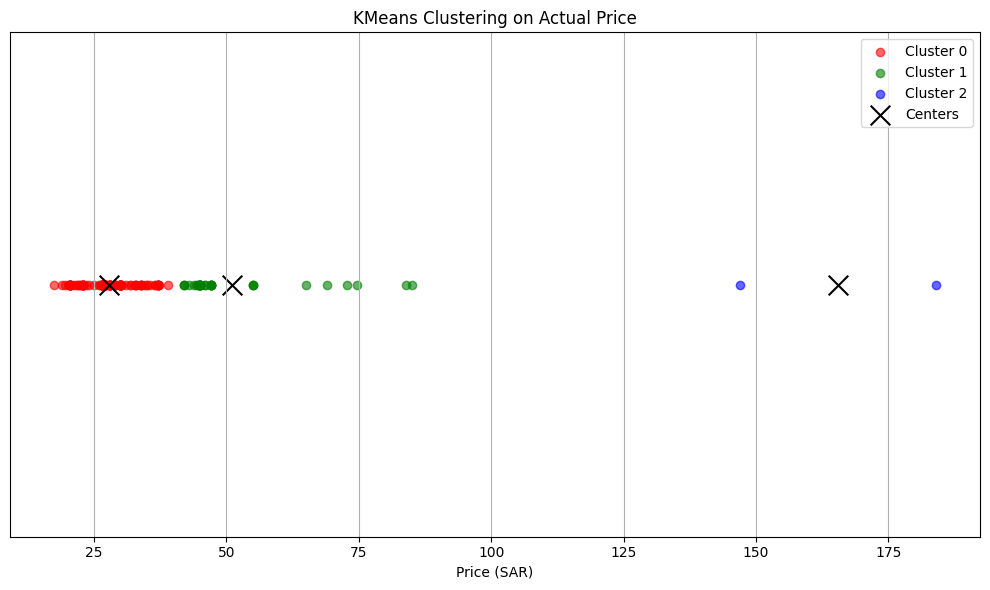

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Make sure 'price_numeric' exists in df_cleaned
df_cleaned = df_cleaned.copy()

# Prepare actual price data
X_price = df_cleaned[["price_numeric"]].values

# Run KMeans on actual prices
k = 3
kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)
kmeans.fit(X_price)
df_cleaned["final_cluster"] = kmeans.labels_

# Plotting clusters based on actual price
plt.figure(figsize=(10, 6))
colors = ['red', 'green', 'blue']

for cluster in range(k):
    cluster_points = df_cleaned[df_cleaned["final_cluster"] == cluster]
    plt.scatter(cluster_points["price_numeric"], [0] * len(cluster_points),
                label=f"Cluster {cluster}", alpha=0.6, color=colors[cluster])

# Cluster centers (actual price values)
centers = kmeans.cluster_centers_.flatten()
plt.scatter(centers, [0] * k, c='black', s=200, marker='x', label='Centers')

# Plot config
plt.title("KMeans Clustering on Actual Price")
plt.xlabel("Price (SAR)")
plt.yticks([])
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [16]:
low = df_cleaned[
    (df_cleaned["final_cluster"] == 0)
]
low

,name,price,page,url,price_numeric,volume,price_per_volume,price_log,price_scaled,cluster_k2,cluster_k3,cluster_k4,cluster_k5,final_cluster
0,AVON Senses Simply Luxurious Body Mist 100ml,30,9,https://www.noon.com/saudi-en/search/?q=body+s...,30.0,100.0,0.300000,-1.203973,1.618720,1,0,1,3,0
1,"Amigo Force Body Splash, 250 ml",33.90,2,https://www.noon.com/saudi-en/search/?q=body+s...,33.9,250.0,0.135600,-1.998046,-0.027529,0,2,0,4,0
2,Amigo PERFUME Splash GREEN 250ml,33.90,3,https://www.noon.com/saudi-en/search/?q=body+s...,33.9,250.0,0.135600,-1.998046,-0.027529,0,2,0,4,0
3,Amigo body splash wild 250 ml,33.90,3,https://www.noon.com/saudi-en/search/?q=body+s...,33.9,250.0,0.135600,-1.998046,-0.027529,0,2,0,4,0
4,BODY FANTASIES Body Fantasies Plumera Perfumed...,34.50,9,https://www.noon.com/saudi-en/search/?q=body+s...,34.5,236.0,0.146186,-1.922872,0.128319,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148,eyup sabri tuncer Peaceful Body Splash 250ml,37,3,https://www.noon.com/saudi-en/search/?q=body+s...,37.0,250.0,0.148000,-1.910543,0.153880,0,0,0,1,0
149,eyup sabri tuncer Pure Love Body Splash 250ml,37,3,https://www.noon.com/saudi-en/search/?q=body+s...,37.0,250.0,0.148000,-1.910543,0.153880,0,0,0,1,0
150,eyup sabri tuncer Silky Touch Body Splash 250ml,37,3,https://www.noon.com/saudi-en/search/?q=body+s...,37.0,250.0,0.148000,-1.910543,0.153880,0,0,0,1,0
151,eyup sabri tuncer Wild Beauty Body Splash 250ml,37,3,https://www.noon.com/saudi-en/search/?q=body+s...,37.0,250.0,0.148000,-1.910543,0.153880,0,0,0,1,0


In [17]:
mid = df_cleaned[
    (df_cleaned["final_cluster"] == 1)
]
mid

,name,price,page,url,price_numeric,volume,price_per_volume,price_log,price_scaled,cluster_k2,cluster_k3,cluster_k4,cluster_k5,final_cluster
17,Buddy Heartbeat Splash Body Spray 250 ml,65,9,https://www.noon.com/saudi-en/search/?q=body+s...,65.00,250.0,0.260000,-1.347074,1.322048,1,0,1,3,1
36,Fiestas Guirca Yellow Body Spray 75 Ml,85,9,https://www.noon.com/saudi-en/search/?q=body+s...,85.00,75.0,1.133333,0.125163,4.374245,1,1,3,2,1
37,HOLLYWOOD Hollywood Body Splash Passion Musk S...,55,3,https://www.noon.com/saudi-en/search/?q=body+s...,55.00,236.0,0.233051,-1.456499,1.095191,1,0,1,3,1
38,HOLLYWOOD Hollywood Love Me Candy Shimmer Body...,55,4,https://www.noon.com/saudi-en/search/?q=body+s...,55.00,236.0,0.233051,-1.456499,1.095191,1,0,1,3,1
39,HOLLYWOOD Hollywood body splash passion musk 2...,55,3,https://www.noon.com/saudi-en/search/?q=body+s...,55.00,236.0,0.233051,-1.456499,1.095191,1,0,1,3,1
44,J.CASANOVA Body splash with oud scent 235 ml,42,3,https://www.noon.com/saudi-en/search/?q=body+s...,42.00,235.0,0.178723,-1.721916,0.544936,0,0,0,1,1
102,Mia Body Splash Paris love You160ml,42,3,https://www.noon.com/saudi-en/search/?q=body+s...,42.00,160.0,0.262500,-1.337504,1.341887,1,0,1,3,1
103,Mia Body Splash Wishes 160ml,43,3,https://www.noon.com/saudi-en/search/?q=body+s...,43.00,160.0,0.268750,-1.313974,1.390669,1,0,1,3,1
106,Pure Beauty Body Splash 250 ml Black City For Men,45,3,https://www.noon.com/saudi-en/search/?q=body+s...,45.00,250.0,0.180000,-1.714798,0.559691,0,0,0,1,1
107,Pure Beauty Body Splash 250 ml Midnight Love F...,45,4,https://www.noon.com/saudi-en/search/?q=body+s...,45.00,250.0,0.180000,-1.714798,0.559691,0,0,0,1,1


In [18]:
high = df_cleaned[
    (df_cleaned["final_cluster"] == 2)
]
high

,name,price,page,url,price_numeric,volume,price_per_volume,price_log,price_scaled,cluster_k2,cluster_k3,cluster_k4,cluster_k5,final_cluster
35,Fabiola Swagger Body Spray 250ML And Secret Bo...,146.95,9,https://www.noon.com/saudi-en/search/?q=body+s...,146.95,250.0,0.5878,-0.531369,3.013143,1,1,1,3,2
144,aldakheeloud Mukhallat Al Shuyukh Perfume 50ml,184,1,https://www.noon.com/saudi-en/search/?q=body+s...,184.00,50.0,3.6800,1.302913,6.815921,1,1,3,2,2


KMeans clusters: 3
DBSCAN clusters: 9 (+ noise)


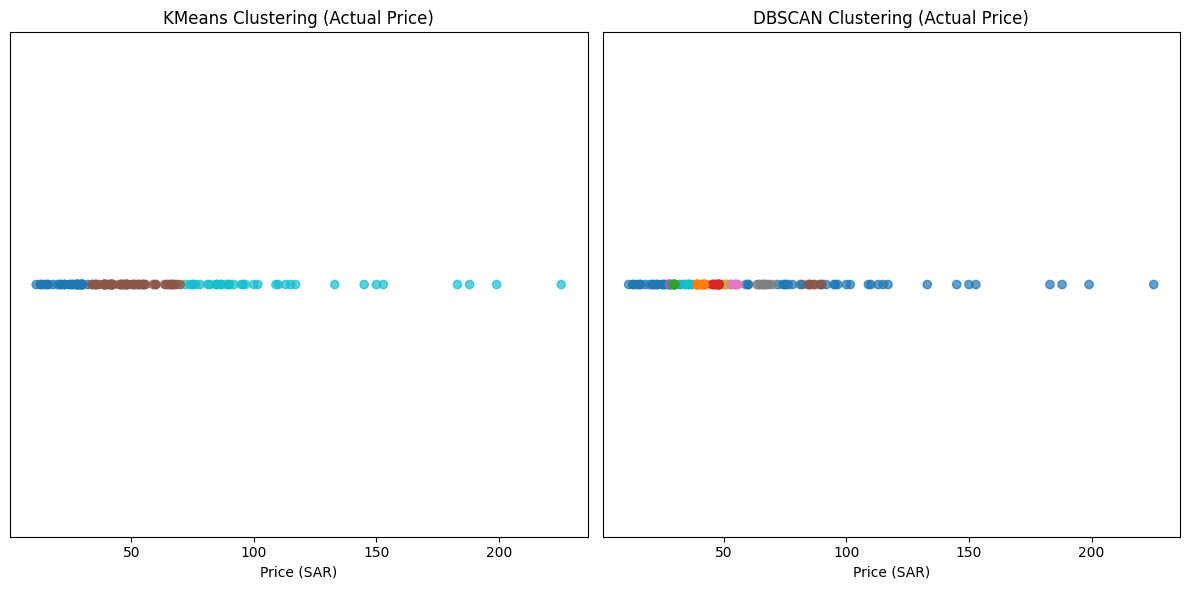

In [ ]:
"""from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

# 1. Run DBSCAN on existing scaled price
dbscan = DBSCAN(eps=0.05, min_samples=5)
df_cleaned["dbscan_cluster"] = dbscan.fit_predict(df_cleaned[["price_scaled"]])

# 2. Compare number of clusters
n_kmeans = df_cleaned["final_cluster"].nunique()
n_dbscan = df_cleaned["dbscan_cluster"].nunique() - (1 if -1 in df_cleaned["dbscan_cluster"].unique() else 0)

print(f"KMeans clusters: {n_kmeans}")
print(f"DBSCAN clusters: {n_dbscan} (+ noise)")

# 3. Visual comparison
plt.figure(figsize=(12, 6))

# KMeans plot
plt.subplot(1, 2, 1)
plt.scatter(df_cleaned["price_numeric"], [0]*len(df_cleaned),
            c=df_cleaned["final_cluster"], cmap="tab10", alpha=0.7)
plt.title("KMeans Clustering (Actual Price)")
plt.xlabel("Price (SAR)")
plt.yticks([])

# DBSCAN plot
plt.subplot(1, 2, 2)
plt.scatter(df_cleaned["price_numeric"], [0]*len(df_cleaned),
            c=df_cleaned["dbscan_cluster"], cmap="tab10", alpha=0.7)
plt.title("DBSCAN Clustering (Actual Price)")
plt.xlabel("Price (SAR)")
plt.yticks([])

plt.tight_layout()
plt.show()
"""

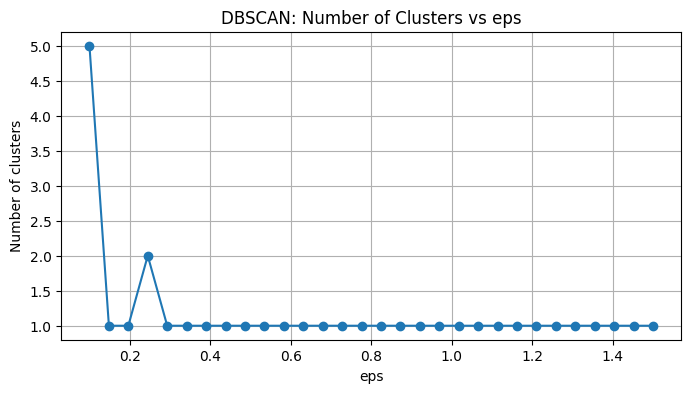

In [ ]:
"""from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

eps_values = np.linspace(0.1, 1.5, 30)
n_clusters_list = []

for eps in eps_values:
    db = DBSCAN(eps=eps, min_samples=5)
    labels = db.fit_predict(df_cleaned[["price_scaled"]])
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_clusters_list.append(n_clusters)

# Plot
plt.figure(figsize=(8, 4))
plt.plot(eps_values, n_clusters_list, marker='o')
plt.title("DBSCAN: Number of Clusters vs eps")
plt.xlabel("eps")
plt.ylabel("Number of clusters")
plt.grid(True)
plt.show()
"""